# Climate Modelling in Python

## What is CliMT?
https://climt.readthedocs.io/en/latest/index.html
Climate Modelling and Diagnostics Toolkit

"a Python based library which provides a modular and intuitive approach to writing numerical models of the climate system. CliMT provides state-of-the art components and an easy-to-use interface to allow writing research quality models without the hassle of modifying Fortran code."

Like the Met Office's Unified Model, the majority of climate models are written in Fortran or C. This is great for performance but it is difficult for researchers to edit and change model configurations. The key benefit of CliMT is that the user can more easily build up complex models, change configurations and swap in various components. 

CliMT uses Fortran code within its components, maintaining the same structure and code as traditional climate models, with high performance. However, the user interacts with CliMT components through Python, which is commonly used for climate model data analysis, allowing the modelling and analysis to be integrated. This opens up more doors for analysis methods that combine statistics or machine learning with the physics. An example of this is probabilistic Bayesian inference which combines a known model with observations to infer latent variables, which can then be used in other aspects of the model.

Models can be built up from basic components to create more and more complex models, without the need for the user to rewrite code at each stage. To do this, CliMT uses Sympl, A System for Modelling Planets, which is designed for writing modular Earth system and planetary models, making them easily readable and understandable. 


Sympl uses `components` to define the model set up and `states` to define the current state of the quantities in the model. According to https://climt.readthedocs.io/en/latest/quickstart.html and https://sympl.readthedocs.io/en/latest/quickstart.html#quickstart, the essential aspects of building a CliMT/Sympl model are:

1. Initialise components
2. Initialise state
3. Step forward in time


In more detail, and as we will see later:
1. Initialise components: 
    * Initialize model components, providing configuration information
    * Use `Wrapper` components to modify the behaviour of any components if necessary.
    
2. Initialise state:
    * Set up grid
    * Use `TendencyStepper` to collect all `TendencyComponent` components into a component that can step the model state forward in time
    * Create a state dictionary using `get_default_state`
3. Step forward in time. At each iteration of the loop:
    * Call `DiagnosticComponent` to compute any derived quantities from prognostic quantities or provide forcing quantities at a given time step.
    * Call `Stepper` components and get a new state dictionary with the updated model quantities and any diag- nostics. Update the initial model state with diagnostics.
    * Call `TendencyStepper` and get a new state dictionary with the updated model quantities and any diagnostics. Update the initial model state with diagnostics.
    * Call any `Monitor` components to store the initial model state (e.g. store to disk, display in real time, send over the network).
    


## 0. Imports

In [1]:
import warnings
warnings.simplefilter("ignore")

import climt
import sympl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs


## 1D Radiation Scheme
To highlight how we put these 3 steps together and to demonstrate what `components` and `states` look like, we will begin with a simple 1D model of a column of air.

#### 1. Initialise components.
    
Components represent the physical processes. Examples that are already built into CliMT include convection, radiation, surface, dynamical core, ice processes. See 
https://climt.readthedocs.io/en/latest/components.html#component-list for more examples.  

Components in CliMT return:
* `tendencies`: the local rate of change of a quantity with time at a given point in space. https://encyclopedia2.thefreedictionary.com/tendency
* `diagnostics`: variables not directly tracked by the model itself, that are instead derived from other variables. https://en.wikipedia.org/wiki/Prognostic_variable

For our simple 1D model, we will provide only 1 component: radiation. We can use the built in radiation scheme `climt.GrayLongwaveRadiation()`.

In [2]:
radiation = climt.GrayLongwaveRadiation()

The output of a component are tedency and diagnostic dictionaries. We can check the properties using `tendency_properties` and `diagnostic_properties`, which tells us the names, dimensions and units of the returned dictionaries.  

In [3]:
print("RADIATION TENDENCIES:", radiation.tendency_properties)
print("RADIATION DIAGNOSTICS:", radiation.diagnostic_properties)

RADIATION TENDENCIES: {'air_temperature': {'units': 'degK s^-1'}}
RADIATION DIAGNOSTICS: {'downwelling_longwave_flux_in_air': {'dims': ['interface_levels', '*'], 'units': 'W m^-2', 'alias': 'lw_down'}, 'upwelling_longwave_flux_in_air': {'dims': ['interface_levels', '*'], 'units': 'W m^-2', 'alias': 'lw_up'}, 'longwave_heating_rate': {'dims': ['mid_levels', '*'], 'units': 'degK day^-1'}}


## 2. Initialise state


Create a `grid`, which is a dictionary of dimensions. We will start with a 1D grid, an atmospheric column of air. 

In [4]:
grid = climt.get_grid(nx=1, ny=1, nz=10)
list(grid.keys())

['atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels',
 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels',
 'surface_air_pressure',
 'time',
 'air_pressure',
 'air_pressure_on_interface_levels',
 'longitude',
 'latitude',
 'height_on_ice_interface_levels']

Next we create the `state` using `get_default_state`. This creates another dictionary of quantities that are quantities required for the grid and for the components that we specify. We are starting with the radiation component

In [5]:
state = climt.get_default_state([radiation], grid_state=grid)
list(state.keys())

['atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels',
 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels',
 'surface_air_pressure',
 'time',
 'air_pressure',
 'air_pressure_on_interface_levels',
 'longitude',
 'latitude',
 'height_on_ice_interface_levels',
 'longwave_optical_depth_on_interface_levels',
 'air_temperature',
 'surface_temperature']

The list of quantities in the state is similar to the grid, but we have additional quantities that are inputs or outputs of our radiation scheme. These are `'longwave_optical_depth_on_interface_levels'`, `'air_temperature'` and
 `'surface_temperature'`.  The call to `climt.get_default_state` sets up the default initial conditions to be realistic for the system, but we can edit these if required. Below, we plot the initial profile of the air temperature against the vertical coordinate, air pressure.

In [6]:
def plot_1D_profile(state, tendencies=None, timestep=None, 
                    variable_name='air_temperature'):
    plt.plot(state[variable_name].values.flatten(), 
         state['air_pressure'].values.flatten(), label=state['time'])
    ax = plt.gca()
    ax.axes.invert_yaxis(), ax.set_ylim(1e5, 100.), 
    ax.set_xlabel(state[variable_name].units)
    ax.set_ylabel('Pa'), ax.set_title(variable_name.replace('_',' '));
    if tendencies is not None:
        plt.plot(state[variable_name].values.flatten() + 
                 tendencies[variable_name].values.flatten()*timestep.seconds, 
                 state['air_pressure'].values.flatten(), label=state['time']+timestep)
        plt.legend()

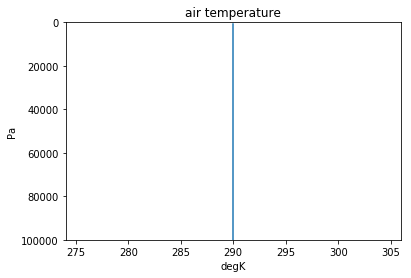

In [7]:
plot_1D_profile(state)

## 3. Step Forward

Now we will take a look at what the radiation component does. The tendencies and diagnostics are calculated by calling `radiation` with the argument `state`. The tendencies are instantaneous, but we can use them to calculate the new model state, after a short period of time. Here we plot the air temperature profile before and after a 20 minute timestep.

In [8]:
from datetime import timedelta
timestep = timedelta(minutes=20)

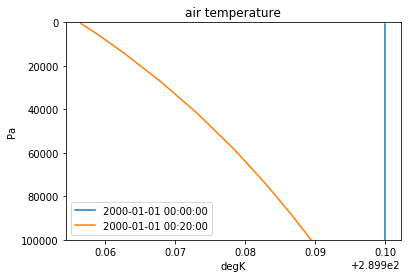

In [9]:
tendencies, diagnostics = radiation(state)
plot_1D_profile(state, tendencies, timestep)

Then we could update the current state using the tendencies provided, and repeat this in a loop e.g.:

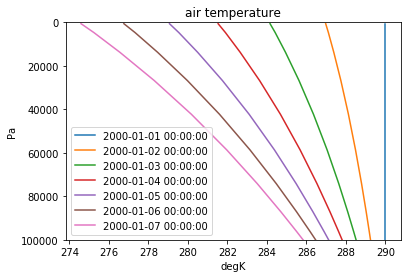

In [10]:
plot_1D_profile(state)
for i in range(3*24*6):
    tendencies, diagnostics = radiation(state)
    state['air_temperature'] += tendencies['air_temperature']*timestep.seconds 
    state['time'] += timestep
    if (i+1)%(3*24) ==0:
        plt.plot(state['air_temperature'].values.flatten(),  
                 state['air_pressure'].values.flatten(), label=state['time'])
plt.legend();

# 3D example with more details
In this example, I'll show how you can build a simple climate model in CliMT with a 3D longitude-latitude-height grid and with more components of the climate system. It involves the same processes as before, with (1) initialising components, (2) initialising the state and (3) stepping forward in time. This time I'll introduce more options that might be useful.

## 1. Initialise components: 

In this example we will provide 3 components:
* longwave radiation `climt.GrayLongwaveRadiation()`
* convection `climt.EmanuelConvection()` 
* simple physics component for the boundary layer, `climt.SimplePhysics()`
following the setup in the paper https://www.geosci-model-dev.net/11/3781/2018/gmd-11-3781-2018.pdf. 

You can put in arguments to these components, but for now let's keep these at the default values (chosen to be sensible for the Earth's system).

At this point, we can also use `Wrapper` components to modify the behaviour of components, if necessary. These are used to change the inputs or outputs of a component to make it apparently work in a different way. 

Below, we use the `UpdateFrequencyWrapper` on the radiation scheme to provide a longer timestep for this component. We also use the `TimeDifferencingWrapper` which provides the output of the components as time tendencies, using a finite diference scheme. This is required on the `SimplePhysics` component because we will be using a spectral dynamical core, which doesn't work well with components that step forward the model in grid space. https://climt.readthedocs.io/en/latest/configuration.html#interfacial-configuration

In [11]:
from datetime import timedelta
timestep = timedelta(minutes=20)

# Convection
convection = climt.EmanuelConvection()

# Radiation: only call every 1 hr
radiation_timestep = timedelta(minutes=60)
radiation = sympl.UpdateFrequencyWrapper(climt.GrayLongwaveRadiation(), 
                                         radiation_timestep)
# Simple physics (boundary layer): use tendencies to work better in spectral space
simple_physics = sympl.TimeDifferencingWrapper(climt.SimplePhysics())

## 2. Initialise state


This time we will build a 3D grid. Then we can collect the components into a time stepper, which will automatically calculate the updated state from the tendencies (https://sympl.readthedocs.io/en/latest/timestepping.html). This is also particularly useful when we have multiple components, as they are all called from one function. Examples for timesteppers include common numerical integrators such as `AdamsBashforth` or `Leapfrog`. 

Here, we will use the `climt.GFSDynamicalCore` which integrates the dynamical core from the Global Forecast System (GFS) model built by the National Centers for Environmental Prediction (NCEP) (https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs). This is written in Fortran (https://github.com/jswhit/gfs-dycore) but we won't need to interact with it directly.

In [12]:
grid = climt.get_grid(nx=62, ny=62, nz=10)
dycore = climt.GFSDynamicalCore(
        [simple_physics, radiation,
         convection], number_of_damped_levels=5
    )
state = climt.get_default_state([dycore], grid_state=grid)
list(state.keys())

['atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels',
 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels',
 'surface_air_pressure',
 'time',
 'air_pressure',
 'air_pressure_on_interface_levels',
 'longitude',
 'latitude',
 'height_on_ice_interface_levels',
 'air_temperature',
 'eastward_wind',
 'northward_wind',
 'divergence_of_wind',
 'atmosphere_relative_vorticity',
 'surface_geopotential',
 'surface_temperature',
 'specific_humidity',
 'surface_specific_humidity',
 'longwave_optical_depth_on_interface_levels',
 'cloud_base_mass_flux']

Here we can see there are quite a few extra quantities in the state, required by 3 components in our model. We will plot some of these.

In [13]:
def plot_vertical_profile(state, plot_names=['eastward_wind', 'air_temperature', 
                          'atmosphere_relative_vorticity']):
    """Plots all zonal winds for different rotation rates"""
    fig = plt.figure(figsize=(10,3))
    for i in range(len(plot_names)):
        ax = fig.add_subplot(1, 3, i+1)
        state[plot_names[i]].coords['lat'] = state['latitude'][:,0]
        state[plot_names[i]].mean(dim='lon').plot.contourf(
            ax=ax, levels=16, robust=True)
        ax.set_title(plot_names[i].replace('_',' '))
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.suptitle('Vertical Profile', fontsize=16)


import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
def plot_sfc_map(state, plot_names = ['eastward_wind', 'air_temperature',
                'divergence_of_wind', 'surface_geopotential']):
    """Plots all zonal winds for different rotation rates"""
    fig = plt.figure(figsize=(9,5))
    for i in range(len(plot_names)):
        ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree())
        state[plot_names[i]].coords['lat'] = state['latitude'][:,0]
        state[plot_names[i]].coords['lon'] = state['longitude'][0]
        if 'surface' in plot_names[i]:
            plot_state = state[plot_names[i]]
        else : 
            plot_state = state[plot_names[i]][0]
        data = plot_state
        data, lon = add_cyclic_point(data, coord=state['longitude'][0])
        lat = state['latitude'][:,0]
        if np.min(data)<0.:
            levels = np.linspace(-np.max(np.abs(data)), np.max(np.abs(data)), 9)
            cmap = 'RdBu_r'
            plt.contourf(lon, lat, data, cmap=cmap, levels = levels, robust=True)

        else:
            plt.contourf(lon, lat, data, robust=True)
        plt.colorbar()
        plt.tight_layout()
        ax.set_title(plot_names[i].replace('_',' '))
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.set_aspect('auto', adjustable=None)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.suptitle('Surface Map', fontsize=16)
    

plt.show()


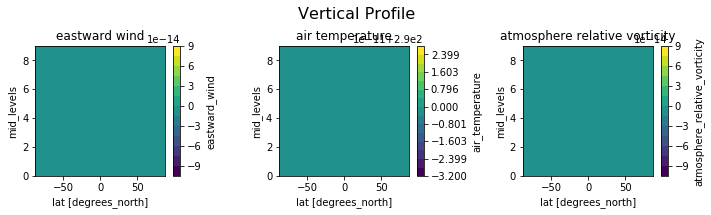

In [14]:
plot_vertical_profile(state)

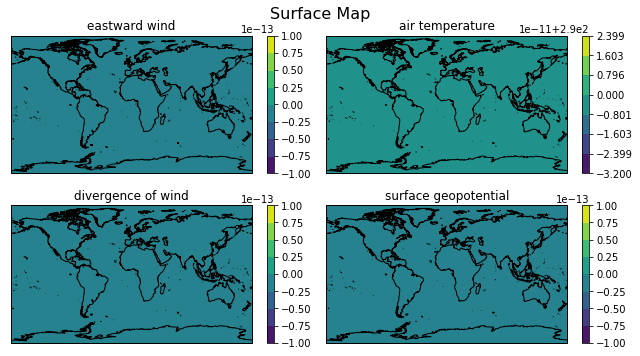

In [15]:
plot_sfc_map(state)

These initial conditions aren't particularly interesting but we can use pre-defined initial conditions from `climt` such as the Dynamical Core Model Intercomparison Project (DCMIP) initial conditions https://climt.readthedocs.io/en/latest/generated/climt.DcmipInitialConditions.html

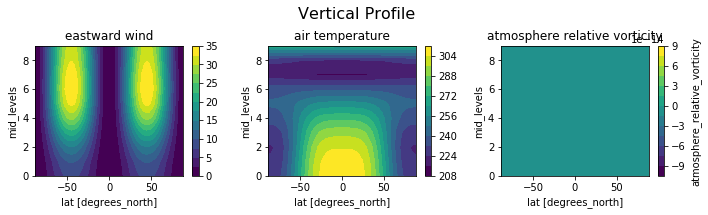

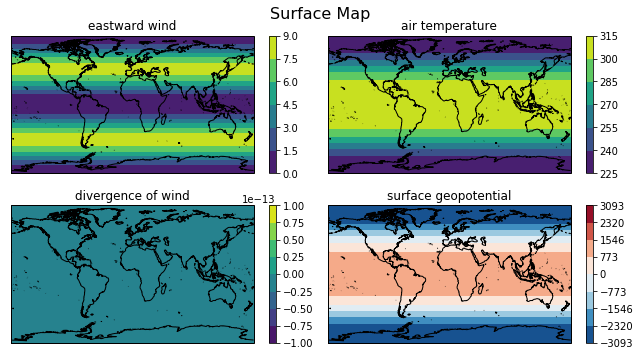

In [16]:
dcmip = climt.DcmipInitialConditions(add_perturbation=False)
init_state = dcmip(state)
state.update(init_state)
plot_vertical_profile(state)
plot_sfc_map(state)

## 3. Step Forward
Now we will put these into a loop to step forward in time. We can call the timestepper, `dycore` on the state for our given timestep. This returns the diagnostics and the new state.



In [17]:
diagnostics, new_state = dycore(state, timestep)


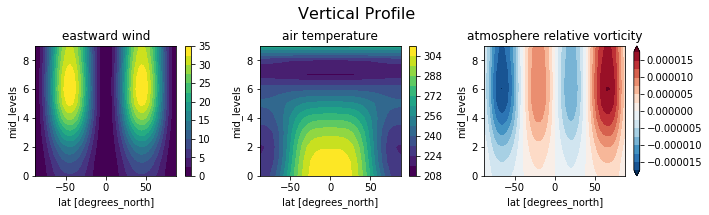

In [18]:
plot_vertical_profile(new_state)

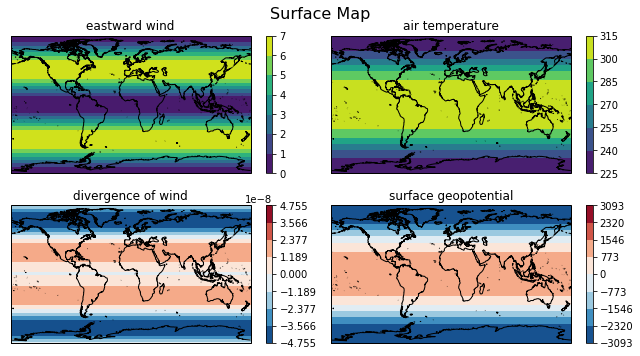

In [19]:
plot_sfc_map(new_state)

Then we update the state with the new state, diagnostics, the time to this. Then we can repeat.

In [20]:
state.update(diagnostics)
state.update(new_state)
state['time'] += timestep

2000-01-01 00:40:00


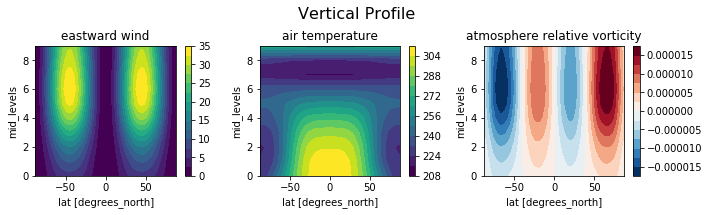

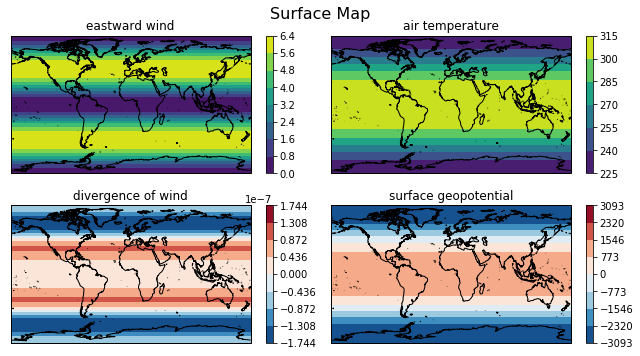

2000-01-15 00:40:00


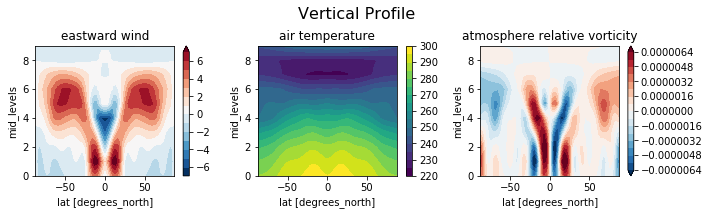

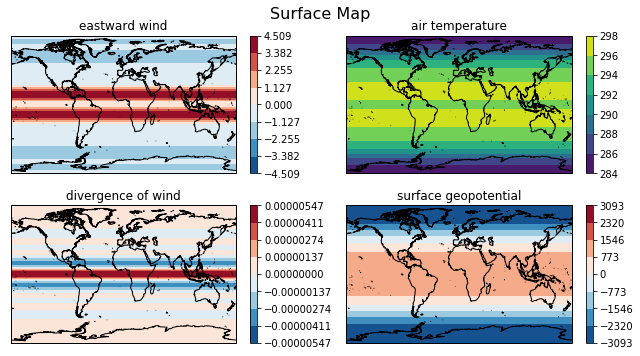

2000-01-29 00:40:00


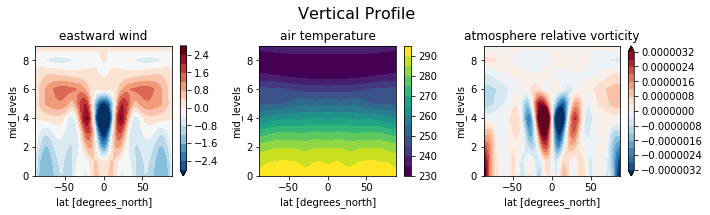

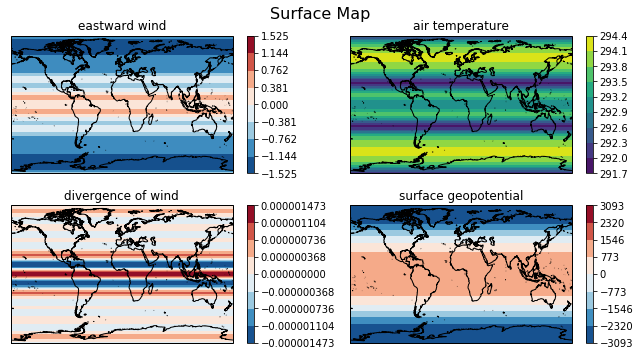

2000-02-12 00:40:00


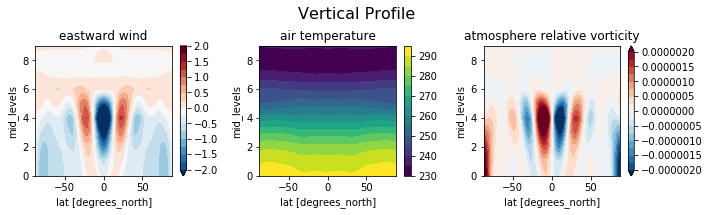

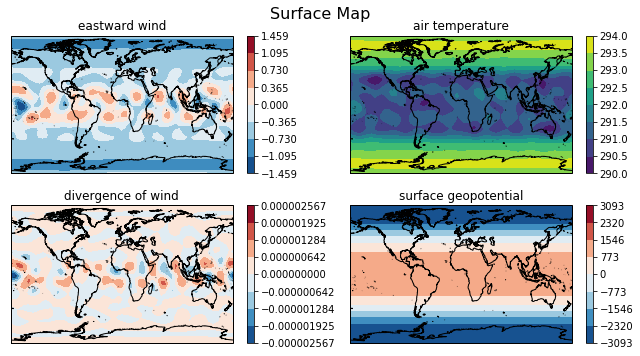

2000-02-26 00:40:00


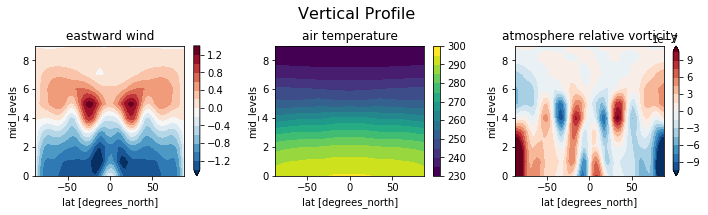

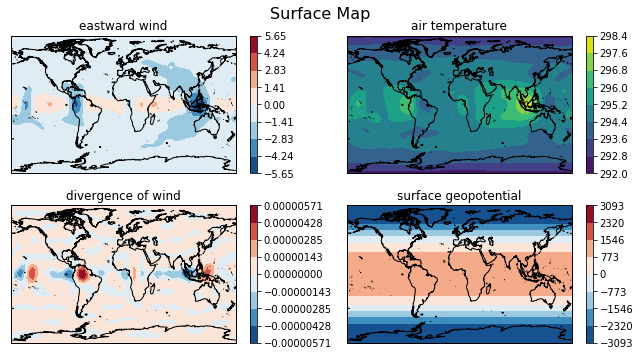

Finished at  2000-02-28 00:20:00
CPU times: user 13min 32s, sys: 48.2 s, total: 14min 20s
Wall time: 12min 9s


In [21]:
%%time
for step in range(24*3*58):
    diagnostics, new_state = dycore(state, timestep)
    state.update(new_state)
    state['time'] += timestep
    if step%(24*3*14) == 0:
        print(state['time'])
        plot_vertical_profile(new_state)
        plot_sfc_map(new_state)
        plt.show()
print("Finished at ", state['time'])

2000-02-28 00:20:00


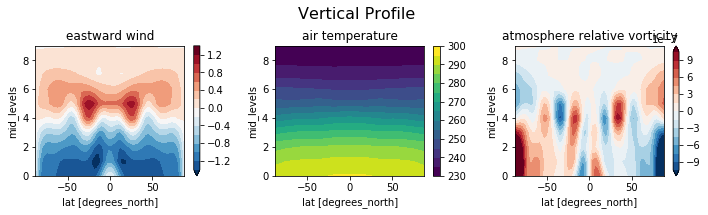

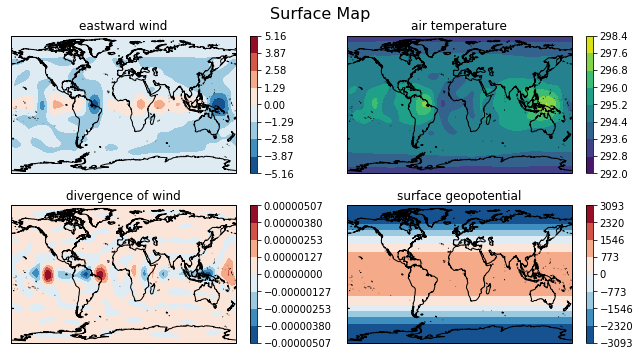

In [22]:
print(state['time'])
plot_vertical_profile(new_state)
plot_sfc_map(new_state)


Now that we have a model, we can put this into the same format as before to set up a pyro model that can do inference based on some data. See the next notebook for more details. 

I'll assume that we observe some of the wind field at a certain time from some 